# Environment setup

In [ ]:
# Connect to Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Import modules
import tensorflow as tf
import numpy as np
import os
import matplotlib.pyplot as plt
import random
import numpy
import imageio
from os import listdir
import pathlib
%pip install rasterio --quiet
import rasterio
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay, cohen_kappa_score
%pip install earthpy --quiet
import earthpy.plot as ep
from matplotlib.colors import ListedColormap, Normalize

# Tensorflow version check
print(tf.__version__)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.9/20.9 MB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 18.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 57.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 78.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.6/16.6 MB 61.1 MB/s eta 0:00:00
2.9.2


In [ ]:
# Set seed
def set_seed(seed: int = 42):
  random.seed(seed)
  np.random.seed(seed)
  tf.random.set_seed(seed)
  tf.experimental.numpy.random.seed(seed)
  os.environ['PYTHONHASHSEED'] = str(seed)
set_seed()

In [ ]:
# Base folder
base = '/content/drive/My Drive/Thesis2'

In [ ]:
# Set variables depending on the type of classes

# # Binary
# Nclasses = 3
# lbl = '/Data/TestBinLbl.tif'
# Weight=[0.0, 1.01, 0.99]
# model_dir = '/UNetBin'
# class_colors_dict = {
#     'Background':      [0.5, 0.5, 0.5, 1],
#     'Forest':     [0,   1,   0,   1],
#     'NonForest': [1, 0, 1, 1],    
# }
# class_colors = {
#     'Forest':     [0,   1,   0,   1],
#     'NonForest': [1, 0, 1, 1],    
# }
# results = '/Results/PredBinUNet.tif'

# Multi
Nclasses = 5
lbl = '/Data/TestMultiLbl.tif'
Weight=[0.00, 1.83, 2.29, 0.5, 0.99]
model_dir = '/UNetMulti'
class_colors_dict = {
    'Background':      [0.5, 0.5, 0.5, 1],  
    'Water':     [0,   0,   1,   1],   
    'Bare soil':     [1,   0,   1,   1],
    'Forest':     [0,   1,   0,   1],
    'Plantation':     [0.7,   1,   0.7,   1], 
}
class_colors = {
    'Water':     [0,   0,   1,   1],   
    'Bare soil':     [1,   0,   1,   1],
    'Forest':     [0,   1,   0,   1],
    'Plantation':     [0.7,   1,   0.7,   1], 
}
results = '/Results/PredMultiUNet.tif'

# # Sub
# Nclasses = 7
# lbl = '/Data/TestSubLbl.tif'
# Weight=[0.00, 1.22, 1.53, 1.65, 0.41, 0.79, 4.09]
# model_dir = '/UNetSub'
# class_colors_dict = {
#     'Background':      [0.5, 0.5, 0.5, 1],
#     'Water':     [0,   0,   1,   1],   
#     'Bare soil':     [1,   0,   1,   1],
#     'Regrowth forest':     [0,   1,   0,   1],
#     'Dense forest':     [0,   0.5,   0,   1],
#     'Mature plantation':     [0.7,   0.7,   0,   1],
#     'Young plantation':     [1,   1,   0,   0.5], 
# }
# class_colors = {
#     'Water':     [0,   0,   1,   1],   
#     'Bare soil':     [1,   0,   1,   1],
#     'Regrowth forest':     [0,   1,   0,   1],
#     'Dense forest':     [0,   0.5,   0,   1],
#     'Mature plantation':     [0.7,   0.7,   0,   1],
#     'Young plantation':     [1,   1,   0,   0.5], 
# }
# results = '/Results/PredSubUNet.tif'

# Load test data and model

In [ ]:
# Load image and make it readable as a numpy matrix
def open_raster(raster_path):
    with rasterio.open(raster_path, 'r') as ds:
        return ds.read() 

# Test data
image = open_raster(base + '/Data/TestImgBig.tif')
image[np.isnan(image)] = 0

label = open_raster(base + lbl)
label[np.isnan(label)] = 0
label[label<0] =0

mask = open_raster(base + '/Data/TestMsk.tif')
mask[np.isnan(mask)] = 0
mask[mask<0] =0

# 3D to 4D
image = np.expand_dims(image, -1)
image = image[:, :, :2720, :]
label = np.expand_dims(label, -1)
label = label[:, :2674, :, :]
mask = np.expand_dims(mask, -1)
mask = mask[:, :2674, :, :]

In [ ]:
# Modified functions from https://github.com/Asad-Ismail/lane_detection/blob/0e2ca0c6796634a4a1d1945828445580dc6507e0/scripts/losses.py

def onehot(y_true, n_classes=Nclasses):
    #Squueeze if the tensor is already 4 dimneional
    if len(y_true.shape) == 4:
        y_true = tf.squeeze(y_true, -1)
    y_true = tf.one_hot(tf.cast(y_true, tf.int32), n_classes)
    y_true = tf.cast(y_true, tf.float32)
    return y_true

def sparse_weighted_crossentropy(weights):
    weights=tf.constant(weights, dtype=tf.float32)
    def loss(y_true, y_pred):
        y_true = onehot(y_true)
        y_pred = tf.keras.activations.softmax(y_pred)
        y_pred = tf.clip_by_value(y_pred, tf.keras.backend.epsilon(), 1-tf.keras.backend.epsilon())
        # loss = y_true * tf.math.log(y_pred) * weights
        loss = weights * ( y_true * tf.math.log(y_pred) + (tf.ones_like(y_true)-y_true) * tf.math.log(tf.ones_like(y_true)-y_pred) )
        loss = -1 * tf.keras.backend.sum(loss, axis=-1)
        loss = tf.keras.backend.mean(loss)
        return loss
    return loss

In [ ]:
# Select the model directory if the loss function is weighted
# model_dir = '/weightedUNetBin'
model_dir = '/weightedUNetMulti'
# model_dir = '/weightedUNetSub'

In [ ]:
# Load the model
# model = tf.keras.models.load_model(base + model_dir) 
model = tf.keras.models.load_model(base + model_dir, custom_objects={'loss': sparse_weighted_crossentropy(Weight)}) 
# model.load_weights('UnetDen169SGD.h5')

# Make a prediction

In [ ]:
# Predict the class of the test image
image_pred = model.predict(image)

1/1 [==============================] - 72s 72s/step


In [ ]:
image_pred[:,:,:,0] = -999

# Adjust data size
image_pred = image_pred[:, :2674, :2674, :]

# Take classes with the highest possibility
image_pred = np.argmax(image_pred, axis=-1)

# 2D to 1D
y_true = label.flatten()
y_pred = image_pred.flatten()

# Remve the background
y_pred[y_true==0] = 0
y_true = y_true[y_true!=0]
y_pred = y_pred[y_pred!=0]

# Performance evaluation

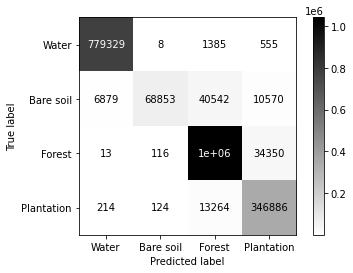

In [ ]:
# Get matrix labels
labels = [k for i, k in enumerate(class_colors_dict)][1:]

# Make confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)
conf_matrix_viewer = ConfusionMatrixDisplay(conf_matrix, display_labels=labels)
conf_matrix_viewer.plot(cmap=plt.get_cmap('binary'))
# conf_matrix_viewer.plot(cmap=plt.get_cmap('binary'), xticks_rotation=45)

In [ ]:
# Calculate the metrics
test_precisions = precision_score(y_true, y_pred, average=None)
test_recalls = recall_score(y_true, y_pred, average=None)
test_F1score = 2 * test_precisions * test_recalls / (test_precisions + test_recalls)
test_kappa = cohen_kappa_score(y_true, y_pred)
test_accuracy = accuracy_score(y_true, y_pred)

# Print these for each class separately
print("Test set precision scores per class")
for i, labeel in enumerate(labels):
    print(f"{labeel}: {test_precisions[i]:.4f}")
print("\n")
print("Test set recall scores per class")
for i, labeel in enumerate(labels):
    print(f"{labeel}: {test_recalls[i]:.4f}") 
print("\n")
print("Test set F1 scores per class")
for i, labeel in enumerate(labels):
    print(f"{labeel}: {test_F1score[i]:.4f}") 
print("\n")
print(f"Test set Kappa score: {test_kappa:.4f}")
print("\n")
print(f'Test avarage accuracy:   {sum(test_recalls)/len(test_recalls):.4f}')
print(f'Test overall accuracy:   {test_accuracy:.4f}')

Test set precision scores per class
Forest: 0.9660
NonForest: 0.9887


Test set recall scores per class
Forest: 0.9869
NonForest: 0.9706


Test set F1 scores per class
Forest: 0.9763
NonForest: 0.9795


Test set Kappa score: 0.9559


Test avarage accuracy:   0.9787
Test overall accuracy:   0.9781


# Visualize and save the predicted labels

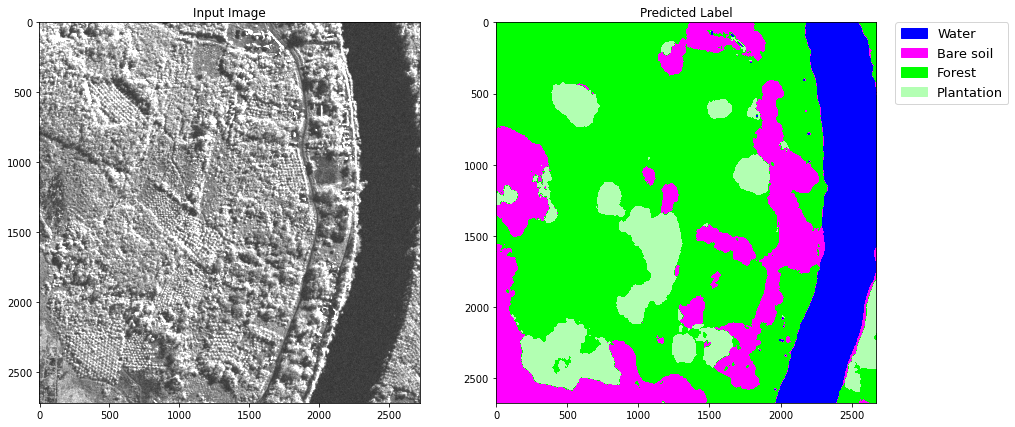

In [ ]:
# Wall-to-wall predictions

# Color map
class_cm = np.array([v for k,v in class_colors.items()])
class_map = class_cm[np.delete(np.unique(label), np.unique(label).max().astype(int)).astype(int)]
cmap = ListedColormap(class_map)

# Plot the image, mask, true label and predicted label
def display(display_list):
  title = ['Input Image', 'Predicted Label']
  fig, ax_pre = plt.subplots(1, 2, figsize=(15, 15))

  for i in range(len(display_list)):
    plt.subplot(1, 2, i+1)
    plt.title(title[i])
    display_list[i] = np.squeeze(display_list[i])
    if i == 0:
      ax_img = plt.imshow(display_list[i], cmap='gray', vmin=0, vmax=0.1)
    if i == 1:
      ax_pre = plt.imshow(display_list[i], cmap=cmap)
      ep.draw_legend(ax_pre, titles=list(class_colors.keys()))
  plt.show()
  return

display([image, image_pred])

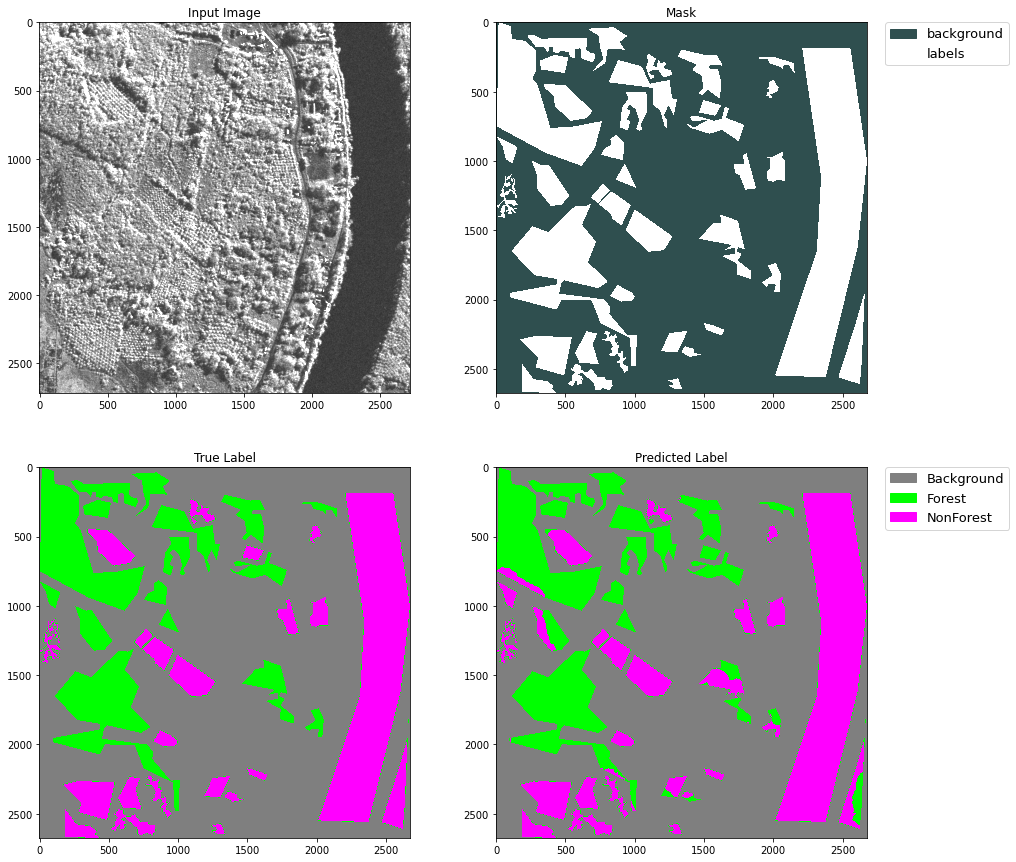

In [ ]:
# Predictions on the test image

np.unique(label)# Color map
class_cm = np.array([v for k,v in class_colors_dict.items()])
class_map = class_cm[np.unique(label).astype(int)]
cmap = ListedColormap(class_map)

# Plot the image, mask, true label and predicted label
def display(display_list):
  title = ['Input Image', 'Mask', 'True Label', 'Predicted Label']
  fig, ((ax_img, ax_msk), (ax_tru, ax_pre)) = plt.subplots(2, 2, figsize=(15, 15))

  for i in range(len(display_list)):
    plt.subplot(2, 2, i+1)
    plt.title(title[i])
    display_list[i] = np.squeeze(display_list[i])
    if i == 0:
      ax_img = plt.imshow(display_list[i], cmap='gray', vmin=0, vmax=0.1)
    if i == 1:
      ax_msk = plt.imshow(display_list[i], cmap=ListedColormap(['darkslategray', 'white']))
      ep.draw_legend(ax_msk, titles=["background", "labels"])
    if i == 2:
      ax_tru = plt.imshow(display_list[i], cmap=cmap)
    if i == 3:
      ax_pre = plt.imshow(display_list[i], cmap=cmap)
      ep.draw_legend(ax_pre, titles=list(class_colors_dict.keys()))
  plt.show()
  return

def create_mask(pred_mask):
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]

def predictions(img, msk, lbl, pred):

    msk = np.reshape(msk, pred.shape)
    pred[msk==0] = 0
    return display([np.squeeze(img), np.squeeze(msk), np.squeeze(lbl), np.squeeze(pred)])

predictions(image, mask, label, image_pred)

In [ ]:
# Select the file name if the loss function is weighted

# results = '/Results/PredWeightBinUNet.tif'
# results = '/Results/PredWeightMultiUNet.tif'
# results = '/Results/PredWeightSubUNet.tif'

In [ ]:
# Save the predicted raster
from rasterio.transform import Affine
img = rasterio.open(base + lbl)
with rasterio.open(
        base + results,
        mode="w",
        driver="GTiff",
        height=image_pred.shape[0],
        width=image_pred.shape[1],
        count=1,
        dtype=image_pred.dtype,
        crs=img.crs,
        transform=img.transform,
) as new_dataset:
        new_dataset.write(np.squeeze(image_pred), 1)